In [1]:
# LinearRegression is a machine learning library for linear regression
from sklearn.linear_model import LinearRegression

# pandas and numpy are used for data manipulation
import pandas as pd
import numpy as np

# matplotlib and seaborn are used for plotting graphs
import matplotlib.pyplot as plt
%matplotlib inline

# yfinance is used to fetch data
import yfinance as yf

import warnings
warnings.simplefilter("ignore")

# Set style using seaborn
import seaborn as sns
sns.set_style('darkgrid')



[*********************100%***********************]  1 of 1 completed


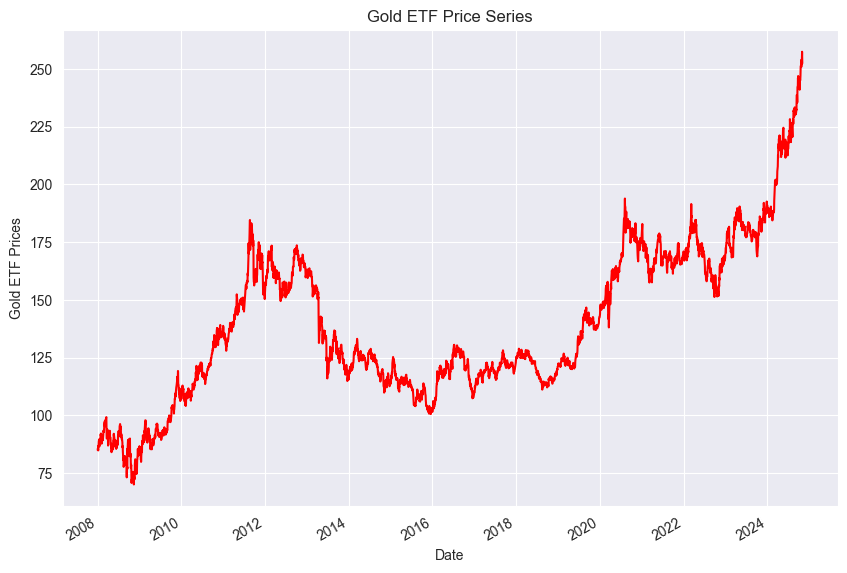

In [2]:
# Read data
Df = yf.download('GLD', '2008-01-01', '2030-5-17', auto_adjust=True)

# Only keep close columns
Df = Df[['Close']]

# Drop rows with missing values
Df = Df.dropna()

# Plot the closing price of GLD
Df.Close.plot(figsize=(10, 7),color='r')
plt.ylabel("Gold ETF Prices")
plt.title("Gold ETF Price Series")
plt.show()

In [3]:
# Define explanatory variables
Df['S_3'] = Df['Close'].rolling(window=3).mean()
Df['S_9'] = Df['Close'].rolling(window=9).mean()
Df['next_day_price'] = Df['Close'].shift(-1)

Df = Df.dropna()
X = Df[['S_3', 'S_9']]

# Define dependent variable
y = Df['next_day_price']

In [4]:
# Split the data into train and test dataset
t = .8
t = int(t*len(Df))

# Train dataset
X_train = X[:t]
y_train = y[:t]

# Test dataset
X_test = X[t:]
y_test = y[t:]

# Create a linear regression model
linear = LinearRegression().fit(X_train, y_train)
print("Linear Regression model")
print("Gold ETF Price (y) = %.2f * 3 Days Moving Average (x1) \
+ %.2f * 9 Days Moving Average (x2) \
+ %.2f (constant)" % (linear.coef_[0], linear.coef_[1], linear.intercept_))

Linear Regression model
Gold ETF Price (y) = 1.18 * 3 Days Moving Average (x1) + -0.18 * 9 Days Moving Average (x2) + 0.35 (constant)


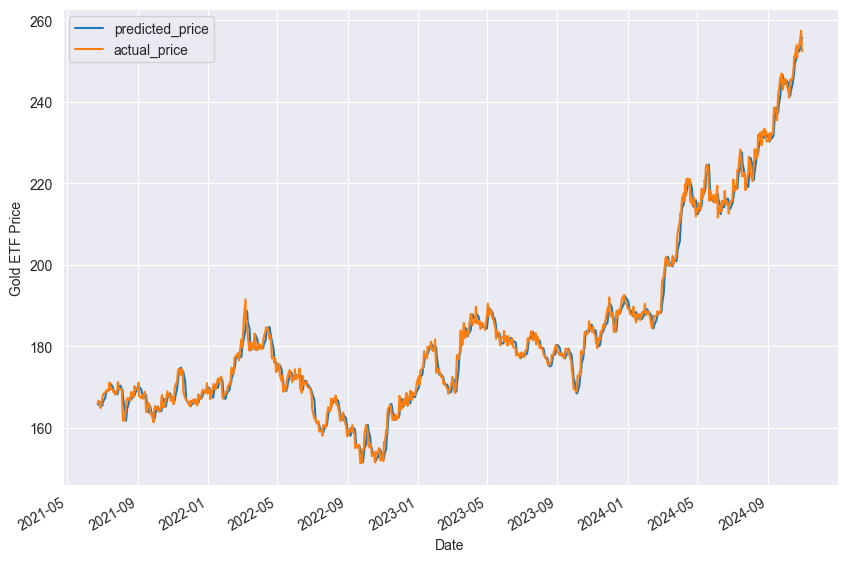

99.26

In [5]:
# Predicting the Gold ETF prices
predicted_price = linear.predict(X_test)
predicted_price = pd.DataFrame(
    predicted_price, index=y_test.index, columns=['price'])
predicted_price.plot(figsize=(10, 7))
y_test.plot()
plt.legend(['predicted_price', 'actual_price'])
plt.ylabel("Gold ETF Price")
plt.show()

# R square
r2_score = linear.score(X[t:], y[t:])*100
float("{0:.2f}".format(r2_score))

In [6]:
gold = pd.DataFrame()

gold['price'] = Df[t:]['Close']
gold['predicted_price_next_day'] = predicted_price
gold['actual_price_next_day'] = y_test
gold['gold_returns'] = gold['price'].pct_change().shift(-1)

In [7]:
gold['signal'] = np.where(gold.predicted_price_next_day.shift(1) < gold.predicted_price_next_day,1,0)
gold.head()

,price,predicted_price_next_day,actual_price_next_day,gold_returns,signal
Date,,,,,
2021-06-23,166.139999,165.830052,166.039993,-0.000602,0
2021-06-24,166.039993,165.666786,166.589996,0.003312,0
2021-06-25,166.589996,165.962530,166.580002,-0.000060,1
2021-06-28,166.580002,166.284531,164.830002,-0.010505,1
2021-06-29,164.830002,165.935169,165.630005,0.004854,0


In [8]:
gold['actual_price_next_day'] = gold.price.shift(-1)
gold['actual_signal'] = np.where(gold.actual_price_next_day.shift(1) < gold.actual_price_next_day,1,0)
gold.tail()

,price,predicted_price_next_day,actual_price_next_day,gold_returns,signal,actual_signal
Date,,,,,,
2024-10-25,253.320007,252.371526,253.330002,0.000039,0,1
2024-10-28,253.330002,253.188898,256.089996,0.010895,1,1
2024-10-29,256.089996,254.301434,257.500000,0.005506,1,1
2024-10-30,257.500000,255.764670,253.509995,-0.015495,1,0
2024-10-31,253.509995,255.790539,NaN,NaN,1,0


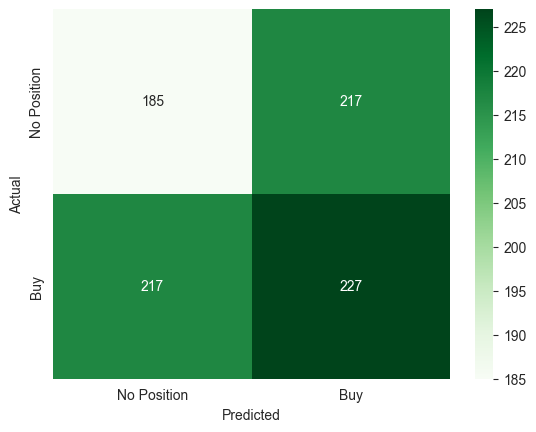

In [9]:
from sklearn.metrics import confusion_matrix
array = confusion_matrix(gold['actual_signal'], gold['signal'])
df = pd.DataFrame(array, index = ['No Position','Buy'], columns = ['No Position','Buy'])

# Plot the heatmap
import seaborn as sns
sns.heatmap(df, annot=True, cmap='Greens', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [10]:
from sklearn.metrics import classification_report
print(classification_report(gold['actual_signal'], gold['signal'], target_names=['No Position','Buy']))

              precision    recall  f1-score   support

 No Position       0.46      0.46      0.46       402
         Buy       0.51      0.51      0.51       444

    accuracy                           0.49       846
   macro avg       0.49      0.49      0.49       846
weighted avg       0.49      0.49      0.49       846



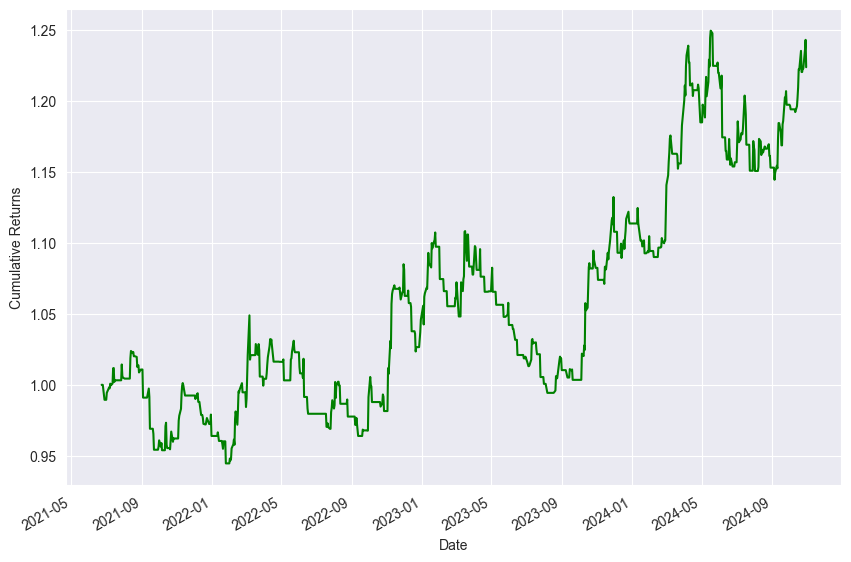

In [11]:
gold['strategy_returns'] = gold.signal * gold['gold_returns']
((gold['strategy_returns']+1).cumprod()).plot(figsize=(10,7),color='g')
plt.ylabel('Cumulative Returns')
plt.show()

In [12]:
'Sharpe Ratio %.2f' % (gold['strategy_returns'].mean()/gold['strategy_returns'].std()*(252**0.5))

'Sharpe Ratio 0.61'

In [20]:
import datetime as dt
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# Fetch current date
current_date = dt.datetime.now()

# Download gold price data
data = yf.download('GLD', '2008-06-01', current_date, auto_adjust=True)

# Calculate moving averages
data['S_3'] = data['Close'].rolling(window=3).mean()
data['S_9'] = data['Close'].rolling(window=9).mean()

# Drop rows with missing values
data = data.dropna()

# Prepare data for training
X = data[['S_3', 'S_9']]  # Features: short-term and long-term moving averages
y = data['Close']  # Target: actual closing prices

# Initialize and train the Linear Regression model
linear = LinearRegression()
linear.fit(X, y)

# Predict gold price using the trained model
data.loc[:, 'predicted_gold_price'] = linear.predict(X)

# Function to recursively predict future prices
def predict_recursive_price(days_ahead_list, model, data):
    last_row = data.iloc[-1].copy()
    
    future_predictions = {}
    
    for days_ahead in days_ahead_list:
        future_date = current_date + pd.DateOffset(days=days_ahead)
        
        # Simulate the future rolling averages
        S_3 = (last_row['S_3'] * 2 + last_row['predicted_gold_price']) / 3
        S_9 = (last_row['S_9'] * 8 + last_row['predicted_gold_price']) / 9
        
        # Create feature set for the future date
        future_X = np.array([[S_3, S_9]])
        
        # Predict future price
        predicted_price = model.predict(future_X)[0]
        
        # Save the result in the predictions dictionary
        future_predictions[days_ahead] = (future_date.strftime('%Y-%m-%d'), round(predicted_price, 2))
        
        # Update the last row's predicted values to simulate future data
        last_row['S_3'] = S_3
        last_row['S_9'] = S_9
        last_row['predicted_gold_price'] = predicted_price
    
    return future_predictions

# Predict for next day, next week, next 3 months, and next year
days_ahead_list = [1, 7, 90, 365]  # Days to predict ahead
future_predictions = predict_recursive_price(days_ahead_list, linear, data)

# Display predictions
for days_ahead, (date, price) in future_predictions.items():
    if days_ahead == 1:
        print(f"Next Day ({date}): Predicted Price = ${price*10.78} / ounce")
    elif days_ahead == 7:
        print(f"Next Week ({date}): Predicted Price = ${price*11} / ounce")
    elif days_ahead == 90:
        print(f"Next 3 Months ({date}): Predicted Price = ${price*12} / ounce")
    elif days_ahead == 365:
        print(f"Next Year ({date}): Predicted Price = ${price*13} / ounce")


[*********************100%***********************]  1 of 1 completed

Next Day (2024-11-05): Predicted Price = $2745.3425999999995 / ounce
Next Week (2024-11-11): Predicted Price = $2801.81 / ounce
Next 3 Months (2025-02-02): Predicted Price = $3056.88 / ounce
Next Year (2025-11-04): Predicted Price = $3312.01 / ounce
